<a href="https://colab.research.google.com/github/Thiago-Borba/HARLEEN-HANSPAL-ResNet/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This code was made by HARLEEN HANSPAL in her youtube video 
https://www.youtube.com/channel/UC74B8V7w8VAV8hhFQ0mX5wg

In [17]:
import torch
from time import perf_counter
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils
from torch.utils.data import DataLoader, random_split
from collections import OrderedDict
%matplotlib inline  

# Nova seção

In [18]:
print(torch.cuda.is_available())

True


In [19]:
data_statistics = ((0.5, 0.5, 0.5), (0.5,0.5,0.5))
train_transform_cifar = transforms.Compose([
    transforms.RandomCrop(32,padding = 4, padding_mode = 'reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace=True) #[-1.1]. data = (data - mean) / std_dev
])
    
test_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*data_statistics, inplace=True) #[-1.1]. data = (data - mean) / std_dev
])
dataset = torchvision.datasets.CIFAR10(root = 'data/', download = True, transform = train_transform_cifar)
test_dataset = (torchvision.datasets.CIFAR10(root = 'data/', download = True, transform = test_transform_cifar, train = False))

Files already downloaded and verified
Files already downloaded and verified


In [20]:
val_ration = 0.2 
train_dataset, val_dataset = random_split(dataset, [int((1-val_ration)* len(dataset)), int(val_ration * len(dataset))])
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_dataset, batch_size, shuffle = True, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size, shuffle = True, pin_memory = True)

tensor([3, 4, 4, 2, 2, 4, 8, 1, 5, 2, 5, 8, 9, 7, 9, 6, 6, 8, 8, 0, 0, 0, 3, 8,
        2, 7, 1, 5, 8, 1, 0, 3, 9, 3, 0, 1, 7, 1, 5, 4, 4, 2, 1, 8, 1, 5, 8, 2,
        2, 5, 6, 5, 4, 3, 3, 3, 1, 9, 7, 6, 0, 4, 6, 3])


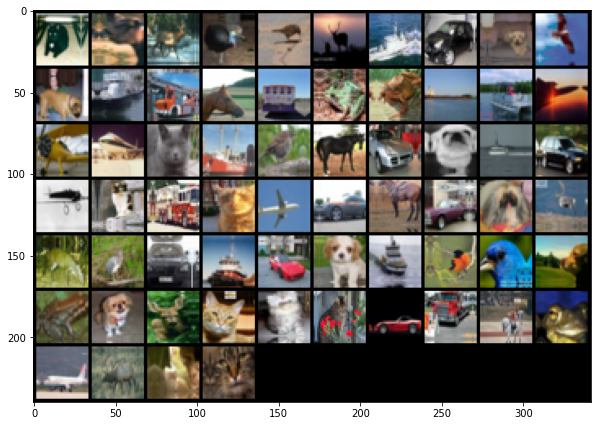

In [21]:
def denormalizer(images, means, std_devs):
    #(image*st_dev + mean
    means = torch.tensor(means).reshape(1,3,1,1)
    std_devs = torch.tensor(std_devs).reshape(1,3,1,1)
    return images * std_devs + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (10,10))
        images = denormalizer(images, *data_statistics)
        ax.imshow(make_grid(images,10).permute(1,2,0))
        print(labels)
        break
        
show_batch(train_dl)
        

In [6]:
def get_default_device():
    return torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

def to_device(entity, device):
    if isinstance(entity, (list, tuple)):
        return [to_device(elem, device) for elem in entity]
    return entity.to(device, non_blocking = True)

class DeviceDataLoader():
    "wrapper around dataloaders to transfer batches to specified devices"
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
    
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [7]:
def conv_block(in_channels,  out_channels,  pool = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace = True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)




class ResnetX(nn.Module):
    
    
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool = True)
        self.res1 = nn.Sequential(OrderedDict([
                ("conv1res1", conv_block(128,128)), 
                ("conv2res1", conv_block(128,128))
            ]))

        self.conv3 = conv_block(128, 256, pool = True)
        self.conv4 = conv_block(256, 512, pool = True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                           nn.Flatten(),
                                           nn.Dropout(0.2),
                                           nn.Linear(512, num_classes))




    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)

    
    
        

In [8]:
model  =  ResnetX(3, 10)
model
[x.shape for x in model.res1.parameters()]

[torch.Size([128, 128, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128, 128, 3, 3]),
 torch.Size([128]),
 torch.Size([128]),
 torch.Size([128])]

In [13]:
def accuracy(logits, labels):
    pred, predClassId = torch.max(logits, dim = 1) 
    return torch.tensor(torch.sum(predClassId == labels).item()/ len(logits))

def evaluate(model, dl, loss_func):
    model.eval()
    batch_losses, batch_accs = [], []                   
    for images, labels in train_dl:
        with torch.no_grad():
              logits = model(images)
        batch_losses.append(loss_func(logits, labels))
        batch_accs.append(accuracy(logits, labels))
    epoch_avg_loss = torch.stack(batch_losses).mean().item()
    epoch_avg_acc = torch.stack(batch_accs).mean()
    return epoch_avg_loss, epoch_avg_acc
    

def train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim):
    optimizer = optim(model.parameters(), max_lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dl))
    
    results = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for images, labels in train_dl:
            logits = model(images)
            loss = loss_func(logits, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()
        epoch_train_loss = torch.stack(train_losses).mean().item()
                       
        model.eval()
        batch_losses, batch_accs = [], []               
        for images, labels in val_dl:
            with torch.no_grad():
                logits = model(images)
            batch_losses.append(loss_func(logits, labels))
            batch_accs.append(accuracy(logits, labels))
           # print("batch_vld_acc", accuracy(logits, labels))
        epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dl, loss_func)
        results.append({'avg_valid_loss': epoch_avg_loss, "avg_valid_acc": epoch_avg_acc, "avg_train_loss" : epoch_train_loss, "lrs" : lrs})
    return results
 
                       
                       
                       
                       






In [10]:
model = to_device(model, device)

In [11]:
epochs = 10
max_lr = 1e-2
loss_func = nn.functional.cross_entropy
optim = torch.optim.Adam

In [ ]:
results = train(model, train_dl, val_dl, epochs, max_lr, loss_func, optim)

In [ ]:
for result in results:
    print(result["avg_valid_acc"])

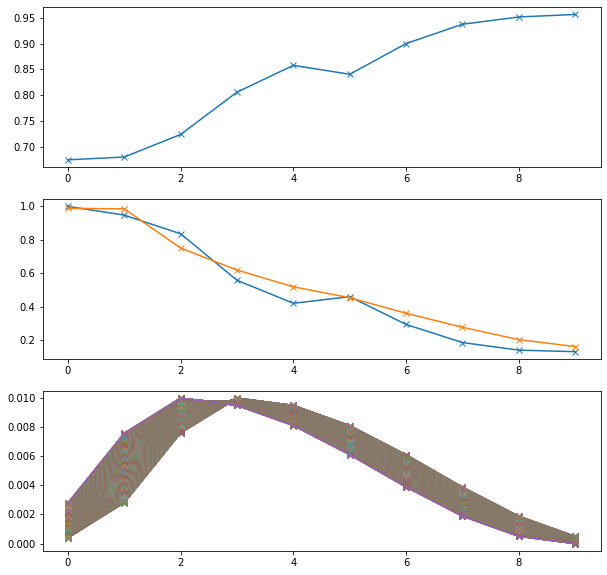

In [16]:
def plot(results, pairs):
    fig, axes = plt.subplots(len(pairs), figsize = (10,10))
    for i, pair in enumerate(pairs):
        for title, graphs in pair.items():
            axes[i].se_title = title
            axes[i].legend = graphs
            axes[i]
            for graph in graphs:
                axes[i].plot([result[graph] for result in results], '-x')
    
    
plot(results, [{"accuracy vs epochs": ["avg_valid_acc"]}, {"Losses vs epochs" : ["avg_valid_loss", "avg_train_loss"]}, {"learning rates vs batches": ["lrs"]}])

In [41]:
 for images, labels in test_dl:
   test_batch = images
   labels = labels
   break

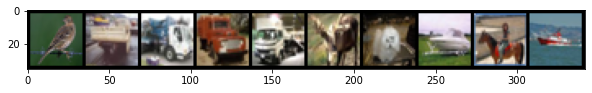

In [51]:
fig, ax = plt.subplots(figsize = (10,10))
images = denormalizer(test_batch[:10], *data_statistics)
ax.imshow(make_grid(images,10).permute(1,2,0))

In [45]:
cuda_test_batch = to_device(test_batch, device)

In [46]:
logits = model(cuda_test_batch)

In [49]:
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
pred, predClassId = torch.max(logits, dim = 1)
print(labels[:10])
print(predClassId[:10])

tensor([2, 9, 9, 9, 9, 4, 5, 8, 7, 8])
tensor([2, 8, 9, 9, 9, 4, 5, 0, 7, 8], device='cuda:0')


tensor([16.2095,  3.1123, 14.4966, 17.8303, 10.1512,  5.2206,  6.9781,  5.6629,
         9.6146, 15.4002], device='cuda:0', grad_fn=<SliceBackward>)